# Create custom blueprints

You may wish to customize DataRobot's blueprints by inserting your own custom code. Leverage [Composable ML](https://docs.datarobot.com/en/docs/modeling/special-workflows/cml/cml-overview.html) to build a new blueprint from scratch or swap out certain components for your own code.

## Overview

This walkthrough uses a synthetic dataset that illustrates a credit card company’s anti-money laundering (AML) compliance program, with the intent of detecting the following money-laundering scenarios:

* A customer spends on the card, but overpays their credit card bill and seeks a cash refund for the difference.
* A customer receives credits from a merchant without offsetting transactions, and either spends the money or requests a cash refund from the bank.

A rule-based engine is in place to produce an alert when it detects potentially suspicious activity consistent with the scenarios above. The engine triggers an alert whenever a customer requests a refund of any amount. Small refund requests are included because they could be a money launderer’s way of testing the refund mechanism or trying to establish refund requests as a normal pattern for their account.

The target feature is `SAR`. It indicates whether or not the alert resulted in an Suspicious Activity Report (SAR) after manual review by investigators, which means that this project is framed as a binary classification problem. The unit of analysis is an individual alert, so the model will be built on the alert level. Each alert will get a score ranging from 0 to 1, indicating the probability of being an alert leading to an SAR. The data consists of a mixture of numeric, categorical and text data.

## Setup

### Import libraries

In [1]:
import os
import time
import warnings

import datarobot as dr
import matplotlib.pyplot as plt
import pandas as pd
import requests

%matplotlib inline
from datarobot.enums import CUSTOM_TASK_TARGET_TYPE
from datarobot_bp_workshop import Visualize, Workshop
import seaborn as sns

warnings.filterwarnings("ignore")

# wider .head()s
pd.options.display.width = 0
pd.options.display.max_columns = 200
pd.options.display.max_rows = 2000

sns.set_theme(style="darkgrid")

RANDOM_SEED = 321

### Import data

In [2]:
df = pd.read_csv("https://s3.amazonaws.com/datarobot_public_datasets/DR_Demo_AML_Alert.csv")
df.head()

,ALERT,SAR,kycRiskScore,income,tenureMonths,creditScore,state,nbrPurchases90d,avgTxnSize90d,totalSpend90d,csrNotes,nbrDistinctMerch90d,nbrMerchCredits90d,nbrMerchCreditsRndDollarAmt90d,totalMerchCred90d,nbrMerchCreditsWoOffsettingPurch,nbrPayments90d,totalPaymentAmt90d,overpaymentAmt90d,overpaymentInd90d,nbrCustReqRefunds90d,indCustReqRefund90d,totalRefundsToCust90d,nbrPaymentsCashLike90d,maxRevolveLine,indOwnsHome,nbrInquiries1y,nbrCollections3y,nbrWebLogins90d,nbrPointRed90d,PEP
0,1,0,3,110300.0,5,757,PA,10,153.80,1538.00,,7,2,0,308.98,0,5,76.90,0.00,0,1,1,45.82,5,6000,0,3,0,6,1,0
1,1,0,2,107800.0,6,715,NY,22,1.59,34.98,card replace billing address billing address,11,2,0,3.28,1,4,60.00,25.02,1,2,1,67.40,0,10000,1,3,0,87,0,0
2,1,0,1,74000.0,13,751,MA,7,57.64,403.48,billing address customer call,4,0,0,0.00,0,4,796.63,393.15,1,2,1,450.69,0,10000,0,3,0,6,0,0
3,1,0,0,57700.0,1,659,NJ,14,29.52,413.28,,7,2,0,59.14,1,3,413.28,0.00,0,1,1,71.43,0,8000,1,5,0,7,2,0
4,1,0,1,59800.0,3,709,PA,54,115.77,6251.58,change request statement late payment bitcoin,16,7,2,785.85,2,3,8928.41,2676.83,1,2,1,2731.39,3,7000,1,1,0,8,1,0


### Connect to DataRobot

Read more about different options for [connecting to DataRobot from the client](https://docs.datarobot.com/en/docs/api/api-quickstart/api-qs.html).

In [4]:
# The URL may vary depending on your hosting preference, this example is for DataRobot Managed AI Cloud
DATAROBOT_ENDPOINT = "https://app.datarobot.com/api/v2"

# The API Token can be found by clicking the avatar icon and then </> Developer Tools
DATAROBOT_API_TOKEN = "<INSERT YOUR DataRobot API Token>"

client = dr.Client(
    token=DATAROBOT_API_TOKEN,
    endpoint=DATAROBOT_ENDPOINT,
    user_agent_suffix="AIA-AE-CBP-111",  # Optional but helps DataRobot improve this workflow
)

dr.client._global_client = client

## Modeling

### Create a DataRobot project

First, create a DataRobot project with the default settings and then initiate Autopilot in Quick mode.

In [5]:
# Create a new project
project_bp_modification = dr.Project.create(
    sourcedata=df,
    project_name="DR_Demo_API_alert_AML_BP_Modification_{}".format(
        pd.datetime.now().strftime("%Y-%m-%d %H:%M")
    ),
)

# Set the project's target and initiate Autopilot in Quick mode
project_bp_modification.set_target(
    target="SAR",
    mode="quick",
    worker_count=-1,
    advanced_options=dr.AdvancedOptions(seed=RANDOM_SEED),
)

# Open the project's Leaderboard to monitor the progress in the UI
project_bp_modification.open_leaderboard_browser()

# Wait for Autopilot to finish
# Set verbosity to 0 if you do not wish to see progress updates
project_bp_modification.wait_for_autopilot(verbosity=0)

print(
    "Custom Project URL: "
    + "https://app.datarobot.com/projects/"
    + project_bp_modification.id
    + "/eda"
)
print("Custom Project ID: " + project_bp_modification.id)

Custom Project URL: https://app.datarobot.com/projects/63f8de78d4c0086769c63003/eda
Custom Project ID: 63f8de78d4c0086769c63003


## Define and train a custom blueprint

You may want to try out different combinations of feature engineering and algorithms that don't currently appear on the Leaderboard. Build a brand new blueprint using [DataRobot's Blueprint Workshop](https://blueprint-workshop.datarobot.com/) directly within the notebook.

### Initialize the Blueprint Workshop

In [6]:
w = Workshop()

First, view the custom tasks available to you.

In [7]:
# List tasks registered in DataRobot
w.list_categories(show_tasks=True)

Custom

  - test_transform_custom (CUSTOMT_6143a63cbaca099dbb26a57a)
  - Write intermediate data (CUSTOMT_61f20e6e2533128c7d769052)
  - byoc_mission2 (CUSTOMC_614e388c12ed7c086b26a48f)
  - byoc_mission2_wip (CUSTOMC_6151f67135d743f97aa85b00)
  - byoc_mission2_update (CUSTOMC_617b1031ffeb5d9835d0d600)
  - updated_werkzog (CUSTOMC_617c16444849732495b447d0)
  - CatBoost Binary Classifier for Demo (CUSTOMC_61a937ed87b42b53e24e2b81)
  - CatBoost Binary Classifier for Demo (CUSTOMC_6201a246718c83c56225b998)
  - CatBoost Binary Classifier for Demo (CUSTOMC_627aa4e8331d9a6fe257d0aa)
  - CatBoost Binary Classifier for Demo (CUSTOMC_627aca08dd1a7dd024f24a25)
  - CatBoost Binary Classifier for Demo (CUSTOMC_627acbf01ad717fa29f96b10)
  - CatBoost Binary Classifier for Demo (CUSTOMC_629fbe76b8ced8506123da2a)
  - CatBoost Binary Classifier for Demo (CUSTOMC_63f7a2e1f6bd35c2f142fa0f)
  - CatBoost Binary Classifier for Demo (CUSTOMC_63f7b40f749572045142f4fe)
  - Passthrough estimator for sentiment pre

In [8]:
# Understand what each task is doing
print(w.Tasks.PNI2.documentation())
help(w.Tasks.PNI2)

https://app.datarobot.com/model-docs/tasks/PNI2-Missing-Values-Imputed.html
Help on PNI2 in module datarobot_bp_workshop.factories object:

class PNI2(datarobot_bp_workshop.friendly_repr.FriendlyRepr)
 |  Missing Values Imputed (quick median)
 |  
 |  Impute missing values on numeric variables with their median and create indicator variables to mark imputed records 
 |  
 |  Parameters
 |  ----------
 |  output_method: string, one of (TaskOutputMethod.TRANSFORM).
 |  task_parameters: dict, which may contain:
 |  
 |    scale_small (s): select, (Default=0)
 |      Possible Values: [False, True]
 |  
 |    threshold (t): int, (Default=10)
 |      Possible Values: [1, 99999]
 |  
 |  Method resolution order:
 |      PNI2
 |      datarobot_bp_workshop.friendly_repr.FriendlyRepr
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __call__(zelf, *inputs, output_method=None, task_parameters=None, output_method_parameters=None, x_transformations=None, y_transformations=None, freeze

### Build a custom Keras blueprint

You can build a new blueprint out of the building blocks DataRobot has provided. Create a new modeling pipeline by selecting the exact preprocessing steps you would like to use for each type of variable and then apply a Keras classifer with custom hyperparameters.

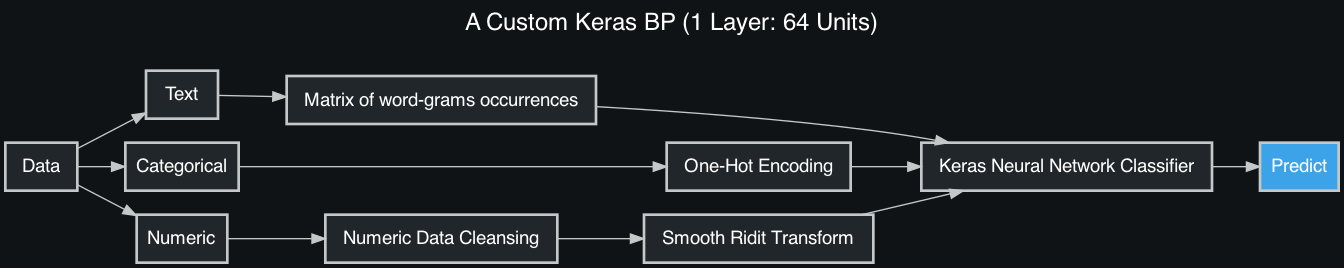

Training requested! Blueprint Id: 47d6ef298fd2abe21d8c123cad527aef


Name: 'A Custom Keras BP (1 Layer: 64 Units)'

Input Data: Categorical | Numeric | Text
Tasks: One-Hot Encoding | Numeric Data Cleansing | Smooth Ridit Transform | Matrix of word-grams occurrences | Keras Neural Network Classifier

In [9]:
# Define the preprocessing path for categorical features
pdm3 = w.Tasks.PDM3(w.TaskInputs.CAT)  # One-hot encoding
pdm3.set_task_parameters(cm=50000, sc=10)

# Define the preprocessing path for numeric features
ndc = w.Tasks.NDC(w.TaskInputs.NUM)  # Numeric data cleaning
rdt5 = w.Tasks.RDT5(ndc)  # Smooth ridit transform

# Define the preprocessing path for text features
ptm3 = w.Tasks.PTM3(w.TaskInputs.TXT)  # Word-gram occurrence matrix
ptm3.set_task_parameters(d2=0.2, mxf=20000, d1=5, n="l2", id=True)

# Define the task relationships
kerasc = w.Tasks.KERASC(rdt5, pdm3, ptm3)
kerasc.set_task_parameters(
    always_use_test_set=1,
    epochs=4,
    hidden_batch_norm=1,
    hidden_units="list(64)",
    hidden_use_bias=0,
    learning_rate=0.03,
    use_training_schedule=1,
)

# Check task documentation:
# kerasc.documentation()

# Build the blueprint
kerasc_blueprint = w.BlueprintGraph(kerasc, name="A Custom Keras BP (1 Layer: 64 Units)").save()
kerasc_blueprint.show()

# Train the newly created blueprint
kerasc_blueprint.train(project_id=project_bp_modification.id, sample_pct=64)

## Create a custom CatBoost estimator

Instead of building a whole new blueprint from scratch, you can leverage the feature engineering Autopilot has already identified on the best-performing blueprint. In this case, xplore how a CatBoost classifer would compare as your ML algorithm.

### Select the execution environment

In [10]:
# While you can create your own environment, DataRobot offers a number of drop-in environments
execution_environments = dr.ExecutionEnvironment.list()
for execution_environment in execution_environments:
    print(execution_environment)

ExecutionEnvironment('[DataRobot] Python 3.9 ONNX Drop-In')
ExecutionEnvironment('Python3 PyTorch Environment')
ExecutionEnvironment('Python3 PyTorch Environment')
ExecutionEnvironment('Python3 PyTorch Environment')
ExecutionEnvironment('Python3 PyTorch Environment')
ExecutionEnvironment('Python3 PyTorch Environment')
ExecutionEnvironment('Python3 PyTorch Environment')
ExecutionEnvironment('Python3 PyTorch Environment')
ExecutionEnvironment('Python 3 YOLOv5')
ExecutionEnvironment('[DataRobot] Julia Drop-In')
ExecutionEnvironment('[DataRobot] Legacy Code Environment')
ExecutionEnvironment('[DEPRECATED] H2O Drop-In')
ExecutionEnvironment('[DataRobot] Python 3.9 PMML Drop-In')
ExecutionEnvironment('[DataRobot] R 4.2.1 Drop-In')
ExecutionEnvironment('[DataRobot] Python 3.9 PyTorch Drop-In')
ExecutionEnvironment('[DataRobot] Java 11 Drop-In (DR Codegen, H2O)')
ExecutionEnvironment('[DataRobot] Python 3.9 Scikit-Learn Drop-In')
ExecutionEnvironment('[DataRobot] Python 3.9 XGBoost Drop-In')
E

We'll use the scikit-learn drop-in environment when defining our custom CatBoost classifier. More information on this environment can be found [here](https://github.com/datarobot/datarobot-user-models/tree/master/public_dropin_environments/python3_sklearn) on GitHub.

In [11]:
# Select the scikit-learn drop-in environment
for execution_environment in execution_environments:
    if execution_environment.name == "[DataRobot] Python 3.9 Scikit-Learn Drop-In":
        BASE_ENVIRONMENT = execution_environment
        break

### Point to CatBoost custom code

The code for a CatBoost classifier can be found in DataRobot's [Community GitHub repo](https://github.com/datarobot-community/custom-models/tree/master/custom_tasks/models/classification/python/catboost).

In [ ]:
# Define the new classifier
binary_classifier = dr.CustomTask.create(
    name="CatBoost Binary Classifier for Demo",
    target_type=CUSTOM_TASK_TARGET_TYPE.BINARY,
)

# Pull in catboost code
custom_task_folder = "catboost/"
task_version = dr.CustomTaskVersion.create_clean(
    custom_task_id=binary_classifier.id,
    base_environment_id=BASE_ENVIRONMENT.id,
    folder_path=custom_task_folder,
)

binary_classifier.refresh()  # In order to see the change, you need to get it from DataRobot
binary_classifier.latest_version

In [13]:
# Build the dependencies
build_info = dr.CustomModelVersionDependencyBuild.start_build(
    custom_model_id=binary_classifier.id,
    custom_model_version_id=task_version.id,
    max_wait=3600,  # 1 hour timeout
)

build_info.build_status

'success'

In [14]:
# Look for the newly created task
w.refresh()
w.search_tasks("catboost")

CatBoost Binary Classifier for Demo: [CUSTOMC_61a937ed87b42b53e24e2b81] 
  - (No description)


CatBoost Binary Classifier for Demo: [CUSTOMC_6201a246718c83c56225b998] 
  - (No description)


CatBoost Binary Classifier for Demo: [CUSTOMC_627aa4e8331d9a6fe257d0aa] 
  - (No description)


CatBoost Binary Classifier for Demo: [CUSTOMC_627aca08dd1a7dd024f24a25] 
  - (No description)


CatBoost Binary Classifier for Demo: [CUSTOMC_627acbf01ad717fa29f96b10] 
  - (No description)


CatBoost Binary Classifier for Demo: [CUSTOMC_629fbe76b8ced8506123da2a] 
  - (No description)


CatBoost Binary Classifier for Demo: [CUSTOMC_63f7a2e1f6bd35c2f142fa0f] 
  - (No description)


CatBoost Binary Classifier for Demo: [CUSTOMC_63f7b40f749572045142f4fe] 
  - (No description)


CatBoost Binary Classifier for Demo: [CUSTOMC_63f8e076bece3f2de342f8a2] 
  - (No description)

## Add the CatBoost estimator to the top-performing blueprint

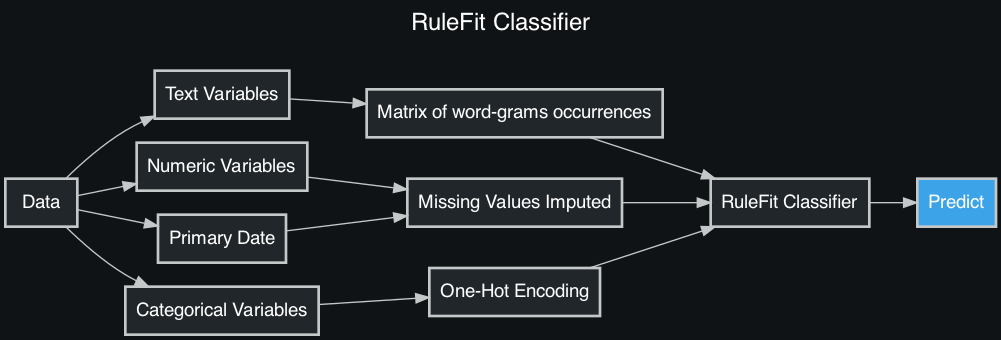

In [15]:
# Get the top-perofming blueprint from the Leaderboard
w.set_project(project_id=project_bp_modification.id)
models = w.project.get_models()
blueprint_id = models[1].blueprint_id
Visualize.show_dr_blueprint(dr.Blueprint.get(project_bp_modification.id, blueprint_id))

In [16]:
# Add the new estimator to the best blueprint from the Leaderboard
bp = w.clone(blueprint_id=blueprint_id)
source_code = bp.to_source_code()
print(source_code)
# Adjust this output to insert the new custom task

w = Workshop(user_blueprint_id='63f8e140bab5b01a13866681', project_id='63f8de78d4c0086769c63003')

pni2 = w.Tasks.PNI2(w.TaskInputs.DATE, w.TaskInputs.NUM)

ptm2 = w.Tasks.PTM2(w.TaskInputs.TXT)
ptm2.set_task_parameters(d2=0.8, mxf=10000, d1=5, nr=[1, 1])

pdm2 = w.Tasks.PDM2(w.TaskInputs.CAT)

rulefitc = w.Tasks.RULEFITC(pni2, ptm2, pdm2)
rulefitc.set_task_parameters(fa=True, ml=5, ms=100000, pc=True, s='auto')

rulefitc_blueprint = w.BlueprintGraph(rulefitc, name='RuleFit Classifier')


In [17]:
# Remove the lines that start with rulefit
rulefit_removed = "\n".join([x for x in source_code.split("\n") if not x.startswith("rulefitc")])
print(rulefit_removed)

w = Workshop(user_blueprint_id='63f8e140bab5b01a13866681', project_id='63f8de78d4c0086769c63003')

pni2 = w.Tasks.PNI2(w.TaskInputs.DATE, w.TaskInputs.NUM)

ptm2 = w.Tasks.PTM2(w.TaskInputs.TXT)
ptm2.set_task_parameters(d2=0.8, mxf=10000, d1=5, nr=[1, 1])

pdm2 = w.Tasks.PDM2(w.TaskInputs.CAT)




In [18]:
# Capture the preprocessing steps


def identify_preprocessing_steps(preprocessing_source_code):
    preprocessing_steps = []
    lines = preprocessing_source_code.split("\n")
    for l in lines:
        components = l.split(" = ")
        if components[0] != "w" and len(components) > 1:
            preprocessing_steps.append(components[0])
    return ", ".join(preprocessing_steps)


preprocessing_string = identify_preprocessing_steps(rulefit_removed)
preprocessing_string

'pni2, ptm2, pdm2'

In [19]:
# Insert the new CatBoost classifier using the task ID obtained from the output of `w.search_tasks("catboost")`
catboost_string = f"""cbc = w.CustomTasks.CUSTOMC_{binary_classifier.id}({preprocessing_string})

cbc_blueprint = w.BlueprintGraph(cbc, name="Catboost Classifier")
cbc_blueprint.show()
"""

print(catboost_string)

cbc = w.CustomTasks.CUSTOMC_63f8e076bece3f2de342f8a2(pni2, ptm2, pdm2)

cbc_blueprint = w.BlueprintGraph(cbc, name="Catboost Classifier")
cbc_blueprint.show()



In [20]:
# Put it all together
print(rulefit_removed + catboost_string)

w = Workshop(user_blueprint_id='63f8e140bab5b01a13866681', project_id='63f8de78d4c0086769c63003')

pni2 = w.Tasks.PNI2(w.TaskInputs.DATE, w.TaskInputs.NUM)

ptm2 = w.Tasks.PTM2(w.TaskInputs.TXT)
ptm2.set_task_parameters(d2=0.8, mxf=10000, d1=5, nr=[1, 1])

pdm2 = w.Tasks.PDM2(w.TaskInputs.CAT)

cbc = w.CustomTasks.CUSTOMC_63f8e076bece3f2de342f8a2(pni2, ptm2, pdm2)

cbc_blueprint = w.BlueprintGraph(cbc, name="Catboost Classifier")
cbc_blueprint.show()



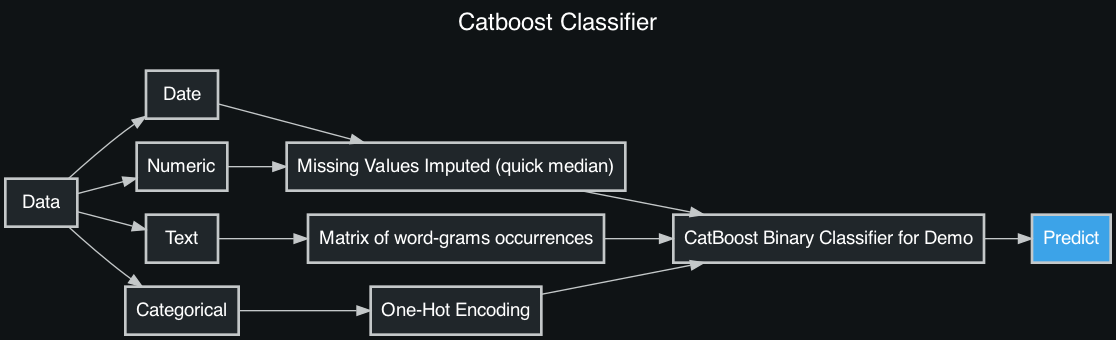

In [21]:
# Execute the string as Python code
exec(rulefit_removed + catboost_string)

In [22]:
# Train the newly created CatBoost blueprint
cbc_blueprint.train(project_id=project_bp_modification.id, sample_pct=64)

Training requested! Blueprint Id: 14cf839f43e0da3725c21a6dfac9ead8


Name: 'Catboost Classifier'

Input Data: Date | Numeric | Text | Categorical
Tasks: Missing Values Imputed (quick median) | Matrix of word-grams occurrences | One-Hot Encoding | CatBoost Binary Classifier for Demo

## Compare performance of the CatBoost estimator to other models

In [23]:
def get_leaderboard(project, metric="LogLoss"):
    """
    A helper method to assemble a dataframe with leaderboard results and print a summary.
    """
    # List of metrics that get better as their value increases
    desc_metric_list = [
        "AUC",
        "Area Under PR Curve",
        "Gini Norm",
        "Kolmogorov-Smirnov",
        "Max MCC",
        "Rate@Top5%",
        "Rate@Top10%",
        "Rate@TopTenth%",
        "R Squared",
        "FVE Gamma",
        "FVE Poisson",
        "FVE Tweedie",
        "Accuracy",
        "Balanced Accuracy",
        "FVE Multinomial",
        "FVE Binomial",
    ]
    asc_flag = False if metric in desc_metric_list else True

    leaderboard = []
    for m in project.get_models():
        leaderboard.append(
            [
                m.model_type,
                m.sample_pct,
                m.metrics[metric]["validation"],
                m.metrics[metric]["crossValidation"],
            ]
        )
    leaderboard_df = pd.DataFrame(
        columns=["model", "pct", f"validation_{metric}", f"cross_validation_{metric}"],
        data=leaderboard,
    )
    leaderboard = (
        leaderboard_df[round(leaderboard_df["pct"]) == 64]
        .sort_values(by=f"cross_validation_{metric}", ascending=asc_flag)
        .reset_index(drop=True)
    )
    return leaderboard

In [25]:
# Once the Catboost classifier has finished training, you can see how it compares to the models built by Autopilot
get_leaderboard(project_bp_modification)

,model,pct,validation_LogLoss,cross_validation_LogLoss
0,RandomForest Classifier (Gini),64.0,0.15996,0.160248
1,RuleFit Classifier,64.0,0.15940,0.163284
2,Light Gradient Boosted Trees Classifier with E...,64.0,0.16804,0.167886
3,Light Gradient Boosting on ElasticNet Predicti...,64.0,0.16838,0.180970
4,eXtreme Gradient Boosted Trees Classifier with...,64.0,0.17005,NaN
5,Generalized Additive2 Model,64.0,0.17039,NaN
6,Catboost Classifier,64.0,0.18154,NaN
7,A Custom Keras BP (1 Layer: 64 Units),64.0,0.19283,NaN
8,Keras Slim Residual Neural Network Classifier ...,64.0,0.20565,NaN
9,Elastic-Net Classifier (mixing alpha=0.5 / Bin...,64.0,0.22788,NaN
